Notebook to produce data regarding 2023 Holiday Service:
https://caltrans.sharepoint.com/:w:/s/DOTPMPHQ-DataandDigitalServices/EVEcAgAwsK1AhL7pQDa22TcBlLF5ZLF-SYOGORhrQrIOCA?e=BX6lkA

There are a significant number of duplicate gtfs files for agencies and it is hard to parse through which is relevant for this research.

Steps:
- Pulls holiday website research data from Services Airtable
- Pulls appropriate agency names from intermediate mart table int_gtfs_quality__daily_assessment_candidate_entities
- Uses these names to query fct_scheduled_trips on holiday and reference dates
- Divide holiday service levels by reference service levels, appropriate by whether the holiday is a weekday or Saturday or Sunday
- Prescribe a gtfs service level by fraction
- Create confusion matrices
- Make another plot

TODOs:
- Instead of query by name, make a join between int_gtfs_quality__daily_assessment_candidate_entities and fct_scheduled_trips by the appropriate method.  This will prevent issues where the gtfs schedule name changes will affect the joins.  This should help ensure the analysis is perfectly replicable in the future.
- Refactor so there aren't multiple lists of text columns
- Method-chain the transformations
- Fix or remove Passio, spirit bus, blossom express
- It's looking suspicious that veteran's day is highthe orange, gtfs greater than website (and xmas eve).  Lets investigate
- Fix ’ vs ' issues in holiday names, get rid of some of the lists in the funcs_vars files.

In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

from dotenv import load_dotenv
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyairtable import Api
from sklearn.metrics import confusion_matrix

from funcs_vars import excel_col_order, holiday_columns, holidays_plus_ref, text_data_cols, plot_confusion_matrices

load_dotenv()
api = Api(os.getenv('AIRTABLE_TOKEN'))

os.environ["CALITP_BQ_MAX_BYTES"] = str(20_000_000_000)
from calitp_data_analysis.sql import query_sql

weekday_holidays = ['Veterans Day (Observed)', 'Thanksgiving Day', 'Day After Thanksgiving', 'Christmas Day', "New Year's Day", 'MLK Day']
saturday_holidays = ['Veterans Day']
sunday_holidays = ['Christmas Eve', "New Year's Eve"]

for day in holidays_plus_ref:
    if day['name'] in saturday_holidays+sunday_holidays+weekday_holidays:
        day['holiday_computed_text'] = f"score_text - {day['name']}"

In [3]:
# Trying to stay consistent with 
# https://github.com/cal-itp/data-infra/blob/main/airflow/plugins/operators/airtable_to_gcs.py
def all_rows_as_df(base_id, table_name):
    all_rows = api.table(base_id=base_id, table_name=table_name).all()

    df = pd.DataFrame(
        [
            {"id":row["id"], **row["fields"]}
            for row in all_rows
        ]
    )
    return df

def takeout_list(x):
    if x is not np.nan:
        return x[0]

CALIFORNIA_TRANSIT_ID = "appPnJWrQ7ui4UmIl"
SERVICES_ID = 'tbl9YmMrJ14D5oPSV'
GTFS_SERVICES = 'tblnVt5FZ2FZmDjDx'
services_df = all_rows_as_df(CALIFORNIA_TRANSIT_ID, SERVICES_ID)
gtfs_services = all_rows_as_df(CALIFORNIA_TRANSIT_ID, GTFS_SERVICES)

services_df['Total VOMS (NTD) (from Provider)'] = services_df['Total VOMS (NTD) (from Provider)'].apply(takeout_list)
services_df = services_df.loc[~services_df['Holiday Schedule – Veterans Day'].isnull(),]
services_df = services_df.loc[services_df['Public Currently Operating Fixed Route'] == 'Yes',]

int_entities = query_sql("""
SELECT 
gtfs_dataset_name,
service_source_record_id,
gtfs_service_data_source_record_id,
use_subfeed_for_reports,
regional_feed_type
FROM `cal-itp-data-infra.staging.int_gtfs_quality__daily_assessment_candidate_entities` 
WHERE gtfs_dataset_type = 'schedule'
AND
date = '2024-01-29'
AND
gtfs_dataset_name != "Bay Area 511 Regional Schedule"
order by organization_name, gtfs_dataset_name ASC
""", as_df=True)

int_entities = pd.merge(int_entities,gtfs_services[['id','Customer Facing']], how='left', left_on='gtfs_service_data_source_record_id',right_on='id').drop(labels=['id'],axis=1)

int_entities = int_entities.query("use_subfeed_for_reports==False | regional_feed_type=='Regional Subfeed'")

services_plus_service_names = pd.merge(services_df,int_entities[['service_source_record_id','gtfs_dataset_name','Customer Facing']]
                                       ,left_on='id',right_on='service_source_record_id',how='left',indicator=True)

services_plus_service_names = services_plus_service_names.loc[~services_plus_service_names['gtfs_dataset_name'].isnull(),]


In [4]:
days_to_consider = []
for each in holidays_plus_ref:
    days_to_consider += [each['date']]

dates_for_query = ','.join(map("'{0}'".format, days_to_consider))

#DowneyLINK replaced their GTFS name from DowneyLINK Schedule to DowneyLINK GMV Schedule on Jan 1st, 2024.  
#This will help collect all their data from both 2023 and 2024.
transit_names_for_query = ','.join(map("'{0}'".format, services_plus_service_names['gtfs_dataset_name'].values)) + ", 'DowneyLINK Schedule'"

trips = query_sql(f"""
select name, service_date, count(trip_instance_key) as total_trips
from `cal-itp-data-infra.mart_gtfs.fct_scheduled_trips` 
WHERE
service_date in ({dates_for_query})
AND
name in ({transit_names_for_query})
group by name, service_date 
""", as_df=True)

#This will consolidate DowneyLink data.
trips = trips.replace(to_replace={'DowneyLINK Schedule':'DowneyLINK GMV Schedule'})

date_to_name = {}
for element in holidays_plus_ref:
    date_to_name[element['date']]=element['name']
trips['service_date'] = pd.to_datetime(trips['service_date']).dt.strftime(date_format='%Y-%m-%d')
trips = trips.replace({"service_date":date_to_name})

#https://hackersandslackers.com/reshaping-pandas-dataframes/
trips_pivoted = pd.pivot_table(trips, index='name',columns='service_date',fill_value = 0,values='total_trips')

df_with_data = pd.merge(services_plus_service_names[['Name','Notes','gtfs_dataset_name','Total VOMS (NTD) (from Provider)', 'Customer Facing']+holiday_columns], 
                        trips_pivoted.reset_index(),how='left', left_on='gtfs_dataset_name', right_on='name',indicator=True)

In [5]:
df_with_data = pd.merge(services_plus_service_names[['Name','Notes','gtfs_dataset_name','Total VOMS (NTD) (from Provider)', 'Customer Facing']+holiday_columns], trips_pivoted.reset_index(),how='left', left_on='gtfs_dataset_name', right_on='name',indicator=True)

print(df_with_data.shape)

df_with_data = df_with_data[~df_with_data['gtfs_dataset_name'].str.contains('Beach Cities Schedule')] 
df_with_data = df_with_data.loc[df_with_data['Holiday Schedule – Thanksgiving Day'] != 'Uncertain',]
#There appear to be duplicates based on the "Transit agency name" as well as on the "GTFS name"
#A spreadsheet manually made to pick out values of agencies names where the gtfs values are duplicated, or the gtfs is not public facing, or if the data
#is considered a good sample.
print(df_with_data.shape)
gtfs_names_dupes = pd.read_csv('extraneous_gtfs_to_remove_holiday_analysis.csv')

#Match so both Name and gtfs_dataset_name match that in gtfs_names dupes, then pull all the non-dupes
locs_with_duplicated_cols_removed = ~(df_with_data['gtfs_dataset_name'].isin(gtfs_names_dupes['gtfs_dataset_name'])&df_with_data['Name'].isin(gtfs_names_dupes['Name']))
df_with_data = df_with_data.loc[locs_with_duplicated_cols_removed]
print(df_with_data.shape)

print(df_with_data.loc[df_with_data['_merge']=='left_only',]['Name'])
#beach cities GMV is active, beach cities is deactivated.
#San Joaquin Schedule works...need to add it back.  Bay Area 511 San Joaquins Schedule never shows up as a trip!
#San Juan Capistrano has no GTFS anymore
#Glendora schedule only works now after Jan 22nd, 2024
df_with_data = df_with_data.loc[df_with_data['_merge']!='left_only',].drop(columns='_merge')
print(df_with_data.shape)

number_columns = list(date_to_name.values())
df_with_data[number_columns] = df_with_data[number_columns].fillna(value=0)

(202, 29)
(188, 29)
(161, 29)
39     San Juan Capistrano Free Weekend Trolley
51                          Amtrak San Joaquins
96                            Glendora Shuttles
144                             Blossom Express
Name: Name, dtype: object
(157, 28)


In [6]:
print(
sum(df_with_data['Reference Sunday'] == 0),
sum(df_with_data['Reference Saturday'] == 0),
sum(df_with_data['Reference Weekday'] == 0),
)

68 28 2


Change holiday schedule values for saturday and sunday holidays to reflect agencies actual schedules

In [7]:
print(df_with_data['Holiday Schedule – Veterans Day'].value_counts())
df_with_data.loc[df_with_data['Reference Saturday'] == 0, 'Holiday Schedule – Veterans Day'] = 'No service'
print(df_with_data['Holiday Schedule – Veterans Day'].value_counts())

Regular service    100
Reduced service     29
No service          28
Name: Holiday Schedule – Veterans Day, dtype: int64
Regular service    88
No service         41
Reduced service    28
Name: Holiday Schedule – Veterans Day, dtype: int64


In [8]:
print(df_with_data['Holiday Schedule – Christmas Eve'].value_counts())
df_with_data.loc[df_with_data['Reference Sunday'] == 0, 'Holiday Schedule – Christmas Eve'] = 'No service'
print(df_with_data['Holiday Schedule – Christmas Eve'].value_counts())

Regular service    116
No service          23
Reduced service     18
Name: Holiday Schedule – Christmas Eve, dtype: int64
Regular service    77
No service         69
Reduced service    11
Name: Holiday Schedule – Christmas Eve, dtype: int64


In [9]:
print(df_with_data["Holiday Schedule – New Year's Day"].value_counts())
df_with_data.loc[df_with_data['Reference Sunday'] == 0, "Holiday Schedule – New Year's Day"] = 'No service'
print(df_with_data["Holiday Schedule – New Year's Day"].value_counts())

No service         111
Reduced service     37
Regular service      9
Name: Holiday Schedule – New Year's Day, dtype: int64
No service         114
Reduced service     36
Regular service      7
Name: Holiday Schedule – New Year's Day, dtype: int64


In [10]:
def complex_divides(df, holiday_count_column, reference_column):
    # Accounts for divide by zero errors
    x = np.where(
      df[reference_column] != 0, df[holiday_count_column]/df[reference_column], 0
    )
    return x.round(2)

for day in weekday_holidays:
    df_with_data[f"score - {day}"] = complex_divides(df_with_data, day, 'Reference Weekday')
for day in saturday_holidays:
    df_with_data[f"score - {day}"] = complex_divides(df_with_data, day, 'Reference Saturday')
for day in sunday_holidays:
    df_with_data[f"score - {day}"] = complex_divides(df_with_data, day, 'Reference Sunday')

In [11]:
score_columns = [col for col in df_with_data.columns if col.startswith("score - ")]

def service_rules(x):
    # print(x)
    if x <= .0001:
        return "No service"
    elif x >= .0001 and x <= .85:
        return "Reduced service"
    elif x > .85:
        return "Regular service"
    else:
        print(x)
    
nums_as_text = df_with_data[score_columns].applymap(service_rules)
nums_as_text.rename(columns=lambda col: col.replace("score - ", "score_text - "), inplace=True)

In [12]:
full_df_for_excel = pd.concat([df_with_data,nums_as_text],axis=1)
full_df_for_excel[excel_col_order].to_csv('full_df_for_excel.csv',index=False)

In [13]:
df_without_values = pd.concat([df_with_data,nums_as_text],axis=1).drop(labels=number_columns+score_columns, axis=1)

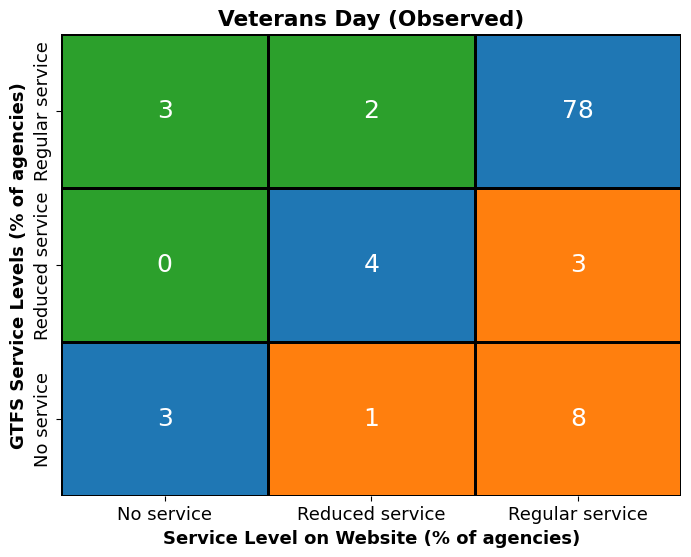

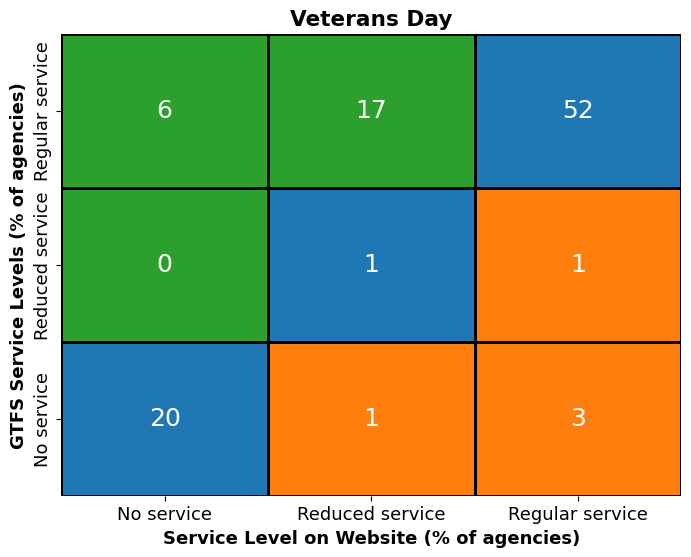

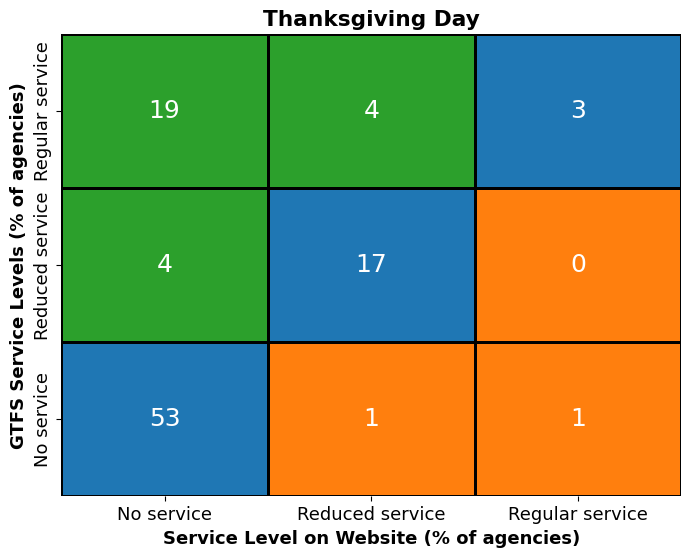

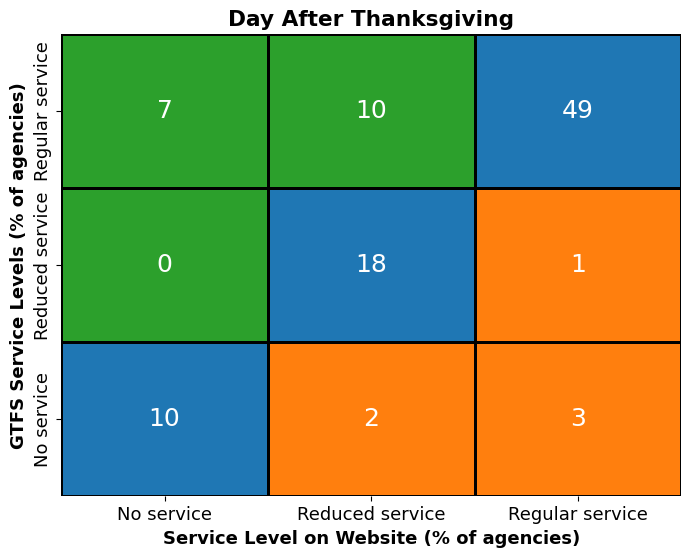

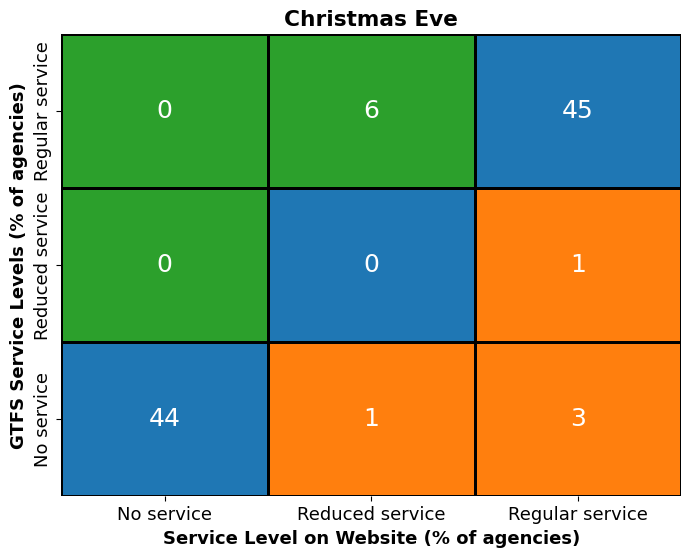

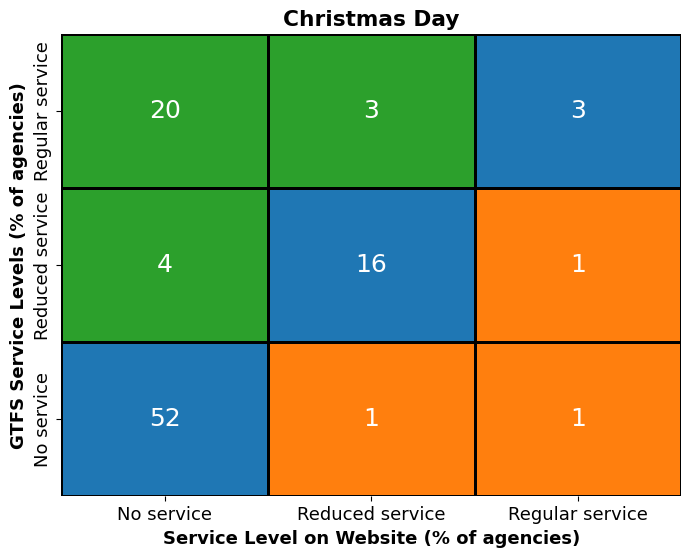

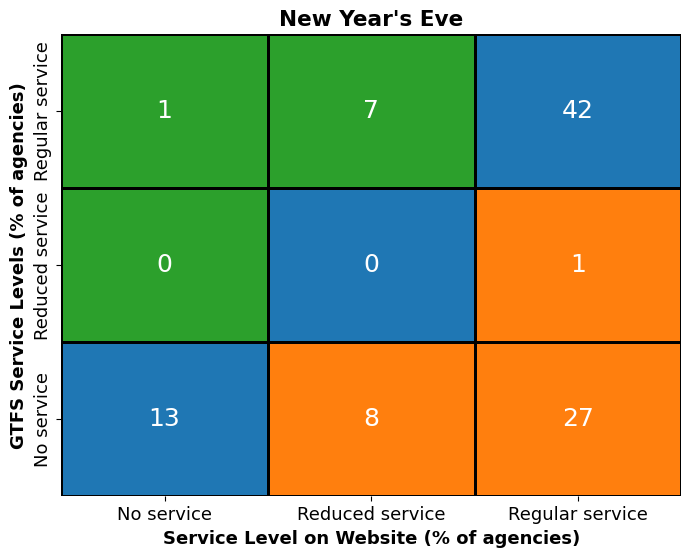

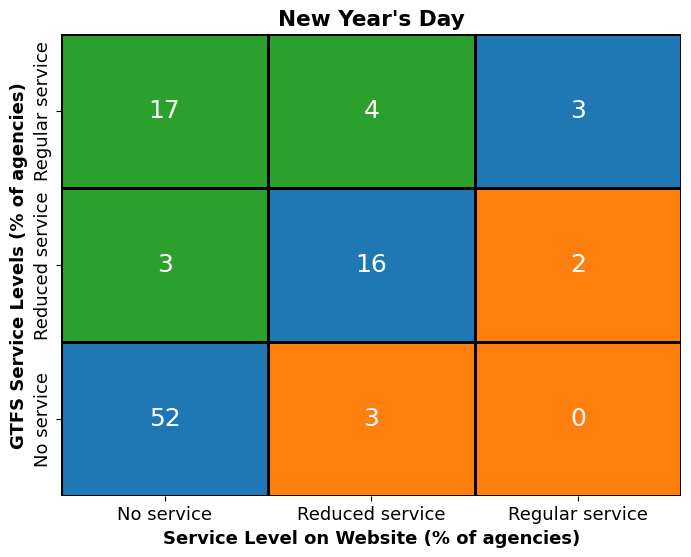

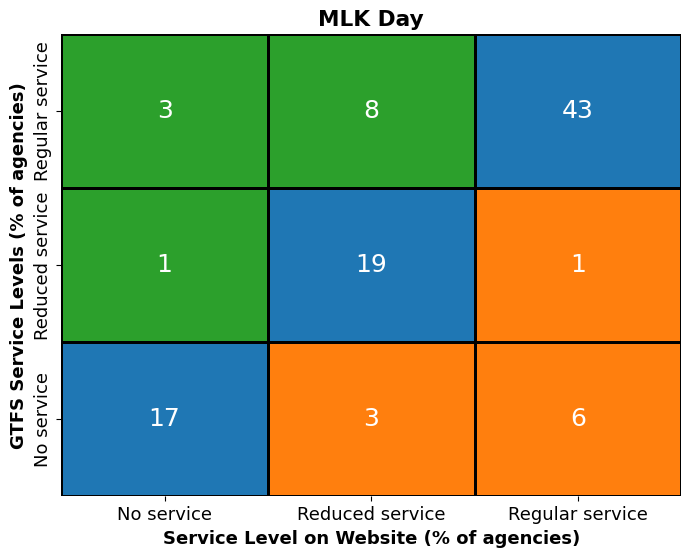

In [14]:
for day in holidays_plus_ref:
    if day['name'] in saturday_holidays+sunday_holidays+weekday_holidays:
        plot_confusion_matrices(df = df_without_values, y_true=day['holiday_computed_text'],
                                y_pred=day['website_name'], title=day['name'])

In [15]:
df = df_without_values
t = []
names = []
for day in holidays_plus_ref:
    if day['name'] in saturday_holidays+sunday_holidays+weekday_holidays:
        y_true = day['website_name']
        y_pred = day['holiday_computed_text']
        desired_order = ['No service', 'Reduced service', 'Regular service']
        cm = confusion_matrix(y_true=df[y_true], y_pred=df[y_pred], labels=desired_order)
        t += [cm.flatten()]
        names.append(day['name'])
j = np.concatenate((t),axis=0).reshape(9,9)

In [16]:
column_order = ["GTFS No service, No service on Website",
 "GTFS Reduced service, No service on Website",
 "GTFS Regular service, No service on Website",
"GTFS No service, Reduced service on Website",
 "GTFS Reduced service, Reduced service on Website",
 "GTFS Regular service, Reduced service on Website",                
 "GTFS No service, Regular service on Website",
 "GTFS Reduced service, Regular service on Website",
 "GTFS Regular service, Regular service on Website"]
plot_df = pd.DataFrame(j, index=names, columns = column_order)
plot_df

,"GTFS No service, No service on Website","GTFS Reduced service, No service on Website","GTFS Regular service, No service on Website","GTFS No service, Reduced service on Website","GTFS Reduced service, Reduced service on Website","GTFS Regular service, Reduced service on Website","GTFS No service, Regular service on Website","GTFS Reduced service, Regular service on Website","GTFS Regular service, Regular service on Website"
Veterans Day (Observed),4,0,4,1,7,3,12,4,122
Veterans Day,32,0,9,1,1,26,4,2,82
Thanksgiving Day,83,6,30,1,26,6,1,0,4
Day After Thanksgiving,16,0,11,3,29,15,5,1,77
Christmas Eve,69,0,0,1,0,10,5,2,70
Christmas Day,82,7,31,2,25,4,1,1,4
New Year's Eve,21,0,2,12,0,11,43,2,66
New Year's Day,82,5,27,5,25,6,0,3,4
MLK Day,26,1,4,5,30,12,9,2,68


In [17]:
plot_df['GTFS matches Website'] = (plot_df['GTFS No service, No service on Website'] 
                                   +plot_df['GTFS Reduced service, Reduced service on Website']
                                   +plot_df['GTFS Regular service, Regular service on Website'])
plot_df['GTFS greater than Website'] = (plot_df['GTFS Reduced service, No service on Website'] 
                                   +plot_df['GTFS Regular service, No service on Website']
                                   +plot_df['GTFS Regular service, Reduced service on Website'])
plot_df['GTFS less than Website'] = (plot_df['GTFS No service, Reduced service on Website'] 
                                   +plot_df['GTFS No service, Regular service on Website']
                                   +plot_df['GTFS Reduced service, Regular service on Website'])

label_order = ['GTFS greater than Website','GTFS matches Website', 'GTFS less than Website']
plot_df[label_order].sum(axis=1)
percentages_df = plot_df[label_order].div(
    plot_df[label_order].sum(axis=1),axis=0).round(2)*100
percentages_df

percentages_df.round(2).to_csv("percentages.csv")

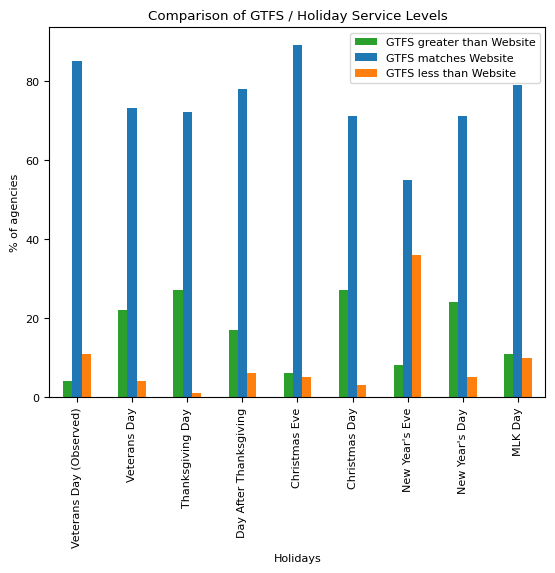

In [18]:
plt.rcParams.update({'font.size': 8})
title = 'Comparison of GTFS / Holiday Service Levels'
colors = ['#2CA02C', '#1F77B4', '#FF7F0E']
percentages_df.plot.bar(color=colors) 
plt.xlabel('Holidays')
plt.ylabel('% of agencies')
plt.title(title)
plt.savefig(f"plots/comparison.png")